In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

Use 'remaining_behavior_ext.csv' as my API anomaly detection dataset. This is a unlabled dataset which contains 11 features, one 'id' column, and over 30k rows of samples.

In [2]:
api_ext = pd.read_csv('remaining_behavior_ext.csv', delimiter=',', index_col=False).drop('Unnamed: 0', axis=1)
api_ext.dataframeName = 'remaining_behavior_ext.csv'
nRow, nCol = api_ext.shape
print(f'There are {nRow} rows and {nCol} columns')
api_ext.head()

There are 34423 rows and 12 columns


,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,behavior,behavior_type,num_sessions,num_users,num_unique_apis,source
0,024aae60-1a81-3f37-bbe6-3f832c919706,7.010387,0.419355,31.0,13040,default,outlier,outlier,1.0,1.0,13.0,E
1,028d67dd-c6d0-329f-a20e-78db9eab7a55,51.419393,0.252336,107.0,330113,default,outlier,outlier,1.0,1.0,27.0,E
2,02d12bf9-5fe2-3d0c-b233-30e02224b686,25.860775,0.275000,40.0,62066,default,outlier,outlier,1.0,1.0,11.0,E
3,0b3aee1e-dc3b-3728-bc55-f57a23446b3d,0.205909,0.818182,11.0,136,default,outlier,outlier,1.0,1.0,9.0,E
4,0dbfffb4-3ed4-3cb2-904d-c348501a996e,0.122125,0.812500,16.0,118,default,outlier,outlier,1.0,1.0,13.0,E


Each data has been categorized into 4 different types according to 'behavior_type' column: normal, outlier, bot and attack. Since this is a anomaly detection, we drop all data whose behavior type is bot or attack. I only retain normal and outlier data. _id is an object value. However, it's an unique id created by the company, and is not related to the classification result. So we decided to drop this feature.

We also need to fill NA with int 0.

In [3]:
# drop attack and bot type
# filling Null with '0'

api_ext.rename(columns = {'_id': 'id','inter_api_access_duration(sec)':'inter_api_access_duration', 'sequence_length(count)':'sequence_length','vsession_duration(min)':'vsession_duration', 'behavior':'classification'}, inplace=True)
api_ext=api_ext.drop(api_ext[api_ext.behavior_type == 'attack'].index)
api_ext=api_ext.drop(api_ext[api_ext.behavior_type == 'bot'].index)
api_ext=api_ext.drop(columns=['id'])
api_ext.inter_api_access_duration = api_ext.inter_api_access_duration.fillna('0')
api_ext.api_access_uniqueness = api_ext.api_access_uniqueness.fillna('0')


Data Attributes

id: user id that requested the API call

inter_api_access_duration(sec): the duration time of the API access in sec

api_access_uniqueness: the uniquenesss of a request value

sequence_length(count): sequence length of the API request

vsession_duration(min): the duration time of the vsession in min

ip_type: the ip type

behavior: the specific behavior of the API

behavior_type: classification results of the API

num_sessions: the number of sessions

num_users: the number of associated users

num_unique_apis: the number of unique APIs

source: the source

api_access_uniqueness, num_sessions, num_users and num_unique_apis are strongly correlated. Other features has relatively low correlation between each other.

ip_type ,source are the categorized object value, implement Label encoding.
Mark outlier as 0, normal as 1.
At last, standardalize the dataset using the StandardScaler

In [7]:
# LabelEncoder and Stannderdize
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
le = LabelEncoder()
api_ext['ip_type']=le.fit_transform(api_ext['ip_type'])
api_ext['source']=le.fit_transform(api_ext['source'])
api_ext['classification']=le.fit_transform(api_ext['classification'])
api_ext[['sequence_length','vsession_duration']] = StandardScaler().fit_transform(api_ext[['sequence_length','vsession_duration']])
api_ext = api_ext.replace({'behavior_type': {'outlier': 1, 'normal': 0}})
api_ext.head()

,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,classification,behavior_type,num_sessions,num_users,num_unique_apis,source
0,7.01039,0.419355,-0.232908,-0.206502,1,1,1,1.0,1.0,13.0,0
1,51.4194,0.252336,0.263562,3.848611,1,1,1,1.0,1.0,27.0,0
2,25.8608,0.275,-0.174116,0.420502,1,1,1,1.0,1.0,11.0,0
3,0.205909,0.818182,-0.363558,-0.371534,1,1,1,1.0,1.0,9.0,0
4,0.122125,0.8125,-0.330896,-0.371764,1,1,1,1.0,1.0,13.0,0


Train data is only from normal dataset, and take 80% of normal data.

Split the remain dataset into 50% validation data and 50% test data.

set overall train data, valid_data, and test_data. Valid and test data set are combined with normal and outliers data.

I will train on train data, fit model and find threshold on valid data, and test our performance on test data.

In [42]:
# split the data accoring to outlier and inlier
# continue split both of them into train(80%) and test(20%)

from sklearn.model_selection import train_test_split


# You will train the autoencoder using only the normal rhythms, 
# which are labeled in this dataset as 0. Separate the normal rhythms from the abnormal rhythms.
normal = api_ext[api_ext['classification'] == 0]
anomaly = api_ext[api_ext['classification'] == 1]
print('normal data:')
print(normal.shape)
print('anomaly data:')
print(anomaly.shape)


# train data is only from normal dataset, and take 80% of normal data
train_data, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=6)

# split the original dataset into 50% validation data and 50% test data.
normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=6)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=6)

# set overall train data, valid_data, and test_data. Valid and test data set are combined normal and outliers
# of course, take the label combined as the same way as data.
valid_data = normal_valid.append(anormal_valid).reset_index(drop=True)
test_data = normal_test.append(anormal_test).reset_index(drop=True)


print('train_data:')
print(train_data.shape)
print('validation_data:')
print(valid_data.shape)
print('test data:')
print(test_data.shape)


normal data:
(8946, 11)
anomaly data:
(24146, 11)
train_data:
(7156, 11)
validation_data:
(12968, 11)
test data:
(12968, 11)


An example of normal and outlier data plot(vsession_duration)

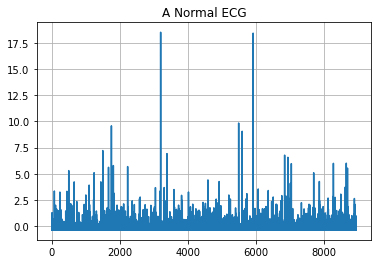

In [43]:
plt.grid()
plt.plot(np.arange(8946), normal['vsession_duration'])
plt.title("A Normal ECG")
plt.show()

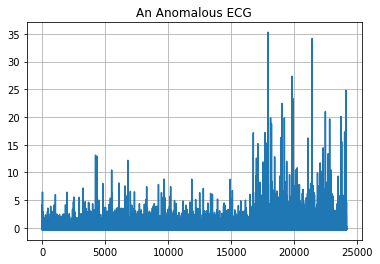

In [44]:
plt.grid()
plt.plot(np.arange(24146), anomaly['vsession_duration'])
plt.title("An Anomalous ECG")
plt.show()

The following is my AutoEncoder model construction.

Dimensionality reduction based anomaly detection method is one of the popular detection methods. It is based on the assumption that the features of normal data are correlated with each other.

Once the model is learned, any input data that cannot be reconstructed back are taken as anomalies.

The most important part of the neural network, and ironically the smallest one, is the bottleneck. The bottleneck exists to restrict the flow of information to the decoder from the encoder, thus, allowing only the most vital information to pass through.
Since the bottleneck is designed in such a way that the maximum information possessed by an image is captured in it, we can say that the bottleneck helps us form a knowledge-representation of the input.
Thus, the encoder-decoder structure helps us extract the most from data and establish useful correlations between various inputs within the network.

AE with linear activation behaves similar to PCA, while the regular AE is able to capture nonlinearity.
~PCA 
pros: Unique solution through singular value decomposition
cons: Linear transformation of raw features only
AE 
pros: Easy to capture complex pattern through nonlinearity and stackup
cons: Without additional constraints, autoencoders may learn an identity mapping of the input

The code size or the size of the bottleneck(hidden layer) is the most important hyperparameter used to tune the autoencoder. The bottleneck size decides how much the data has to be compressed. This can also act as a regularisation term.

I use relu as my encoder activation function, and sigmoid as my decoder activation function.

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError


# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    """
    Parameters
    ----------
    output_units: int
    Number of output units
  
    code_size: int
    Number of units in bottle neck
    """

    def __init__(self, output_units, code_size=8):
        super().__init__()
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])
  
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
    

Notice that the autoencoder is trained using only the normal data, but is evaluated using the full validation set.
Use Mean squared logarithmic error (MSLE) as loss function.
Adam optimizer as learning rate.
Normalize using Min-Max scaler to set data in between 0-1.


In [47]:
# Notice that the autoencoder is trained using only the normal ECGs, 
# but is evaluated using the full val set.

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = train_data.copy()
X_train = X_train.drop(['classification'], axis=1)
x_train_scaled = min_max_scaler.fit_transform(X_train)

X_valid = valid_data.copy()
X_valid = X_valid.drop(['classification'], axis=1)
x_val_scaled = min_max_scaler.transform(X_valid)


model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_val_scaled, x_val_scaled)
)
model.save_weights('models/savedmodels/autoencoder/')
model.encoder.summary()
model.decoder.summary()


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

We can plot the MSLE train loss curve and MSLE validation loss curve to observe the performance.

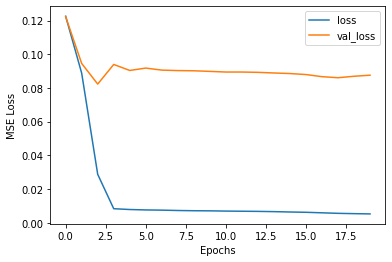

In [48]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()


Note that we use train set to get our reconstruction_values, and we test the performance scores on our test data that have not been used.

We need to find best threshold, and we first try two naive ways. 

The first way is to choose a threshold value that is one standard deviations above the mean:

np.mean(train_loss.numpy()) + np.std(train_loss.numpy())

And the second way is to choose a threshold value that is 95% of the reconstruction error value based on MSLE loss:

np.percentile(reconstruction_errors, 95)

In [85]:
# Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    train_loss = tf.keras.losses.msle(reconstructions, x_train_scaled)
    plt.hist(train_loss[None,:], bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()
    # threshold for anomaly scores
    threshold = np.mean(train_loss.numpy()) + np.std(train_loss.numpy())
    print("threshold seleted to: " + str(threshold))
    return threshold

def find_threshold_method_two(model, x_train_scaled):
    # another method to find threshold
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

    threshold_2 = np.percentile(reconstruction_errors, 95)
    print("threshold2 seleted to: " + str(threshold_2))
    return threshold_2


This is my anomaly(loss) score helper function to help determine threshold.

In [86]:
def compute_anomaly_score(model, df):
    preds = model.predict(df)
    mse = np.mean(np.power(df - preds, 2), axis=1)
    return mse


Print the performance result function, which input is a specific threshold, test dataset and corresponding labels.

In [80]:
def test_result(threshold, test_data, labels):
    loss = compute_anomaly_score(model, test_data)
    pred =  tf.math.less(loss, threshold)
    f1_totol = f1_score(labels, pred)
    print("Accuracy = {}".format(accuracy_score(labels, pred)))
    print("Precision = {}".format(precision_score(labels, pred)))
    print("Recall = {}".format(recall_score(labels, pred)))
    print("F1 = {}".format(f1_score(labels, pred)))

The performance results of two simple way to select threshold are as following, which based on how well the test data match their test labels.

The test result is considerably poor.

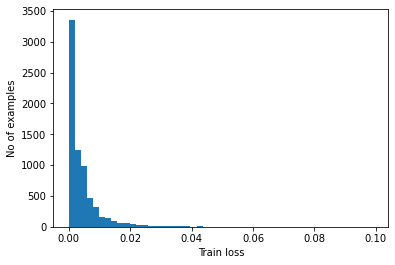

threshold seleted to: 0.010828985830982971
threshold2 seleted to: 0.015957395165237975
Accuracy = 0.06901603948180136
Precision = 0.0
Recall = 0.0
F1 = 0.0
Accuracy = 0.023827884022208513
Precision = 0.0
Recall = 0.0
F1 = 0.0


In [84]:
X_test = test_data.copy()
X_test = X_test.drop(['classification'], axis=1)
x_test_scaled = min_max_scaler.fit_transform(X_test)

threshold = find_threshold(model, x_train_scaled)
threshold_2 = find_threshold_method_two(model, x_train_scaled)

test_result(threshold, x_test_scaled, test_data['classification'])
test_result(threshold_2, x_test_scaled, test_data['classification'])


Reference:
https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder


Two previous simple selection of threshould don't work well. We try to find best threshold by iteration potential values.

We first compute mse anomaly socores both of *normal_train_data* and *outlier_validation_data*. Then we loop to find the best one from all threshold candidates.

In [87]:
normal_train_data_scaled = min_max_scaler.fit_transform(x_train_scaled)
inlier_scores = compute_anomaly_score(model, normal_train_data_scaled)

x_anormal = anormal_valid.copy()
x_anormal = x_anormal.drop(['classification'], axis=1)
x_anormal = min_max_scaler.transform(x_anormal)
outlier_scores = compute_anomaly_score(model, x_anormal)

print(inlier_scores)
print(outlier_scores)

[0.00013387 0.00077238 0.0093122  ... 0.00040412 0.03210171 0.00567915]
[ 42.94482374  22.85162431 491.20048822 ... 231.40231777  24.19619127
  16.20332175]


These are my functions to select best threshold through iteration.

Iterate all threshold candidates through inlier_scores and outlier_scores as previously counted. Test it on *validation dataset* to select best f1 score to select best threshold.

In [67]:
import os
def get_scores_and_labels(outlier_score, inlier_score):
    zero_vec = np.zeros(len(inlier_score))
    one_vec = np.ones(len(outlier_score))

    all_scores = list(inlier_score) + list(outlier_score)
    all_labels = list(zero_vec) + list(one_vec)

    return all_scores, all_labels

def test_threshold(threshold, loss, y):
    y_pred = np.array([1 if e > threshold else 0 for e in loss]).astype(int)
    f1_totol = f1_score(y, y_pred)
    metrics = {"f1": f1_totol,
               "threshold": round(threshold, 3)}
    return metrics

def evaluate_model(inlier_score, outlier_score, model_name="_", show_plot=True):
    image_directory = "metrics/" + model_name
    if not os.path.exists(image_directory):
        os.makedirs(image_directory)

    all_scores, all_labels = get_scores_and_labels(
        outlier_score, inlier_score)
    all_thresholds = list(set(all_scores))
    all_thresholds.sort()

    print(str(len(all_thresholds)) + "unique thresholds")
    print("Testing all thresholds to find best accuracy ...")
    metric_holder = []

    for threshold in all_thresholds:
        metrics = test_threshold(threshold, all_scores, all_labels)
        metric_holder.append(metrics)

    print("Threshold testing complete ...")

    metric_df = pd.DataFrame(metric_holder)
    max_acc = metric_df.sort_values(
        by='f1', ascending=False, na_position='first').iloc[0]
    print('We select best accuracy test on validation dataset to find best threshold, which is ' + str(dict(max_acc)))
    return max_acc['threshold']


As we determined the threshold through *training normal data as inlier scores*, and *anormal_validation data as outlier scores*, we take the threshold to test it in all *test dataset* which name is x_test_scaled.


In [68]:
threshold_3 = evaluate_model(inlier_scores, outlier_scores, model_name="autoencoder", show_plot=True)


18964unique thresholds
Testing all thresholds to find best accuracy ...
Threshold testing complete ...
We select best accuracy test on validation dataset to find best threshold, which is {'f1': 1.0, 'threshold': 0.209}


As we get best threshold tested on validation dataset, we put this threshold into the test of test dataset.

And here's our result.

In [77]:
X_test = test_data.copy()
X_test = X_test.drop(['classification'], axis=1)
x_test_scaled = min_max_scaler.fit_transform(X_test)
test_result(threshold_3, x_test_scaled, test_data['classification'])

Accuracy = 0.8150061690314621
Precision = 0.9219295184926727
Recall = 0.8754245009525388
F1 = 0.8980753706929515
